In [118]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, converge_ZNE_loocv

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection

[]

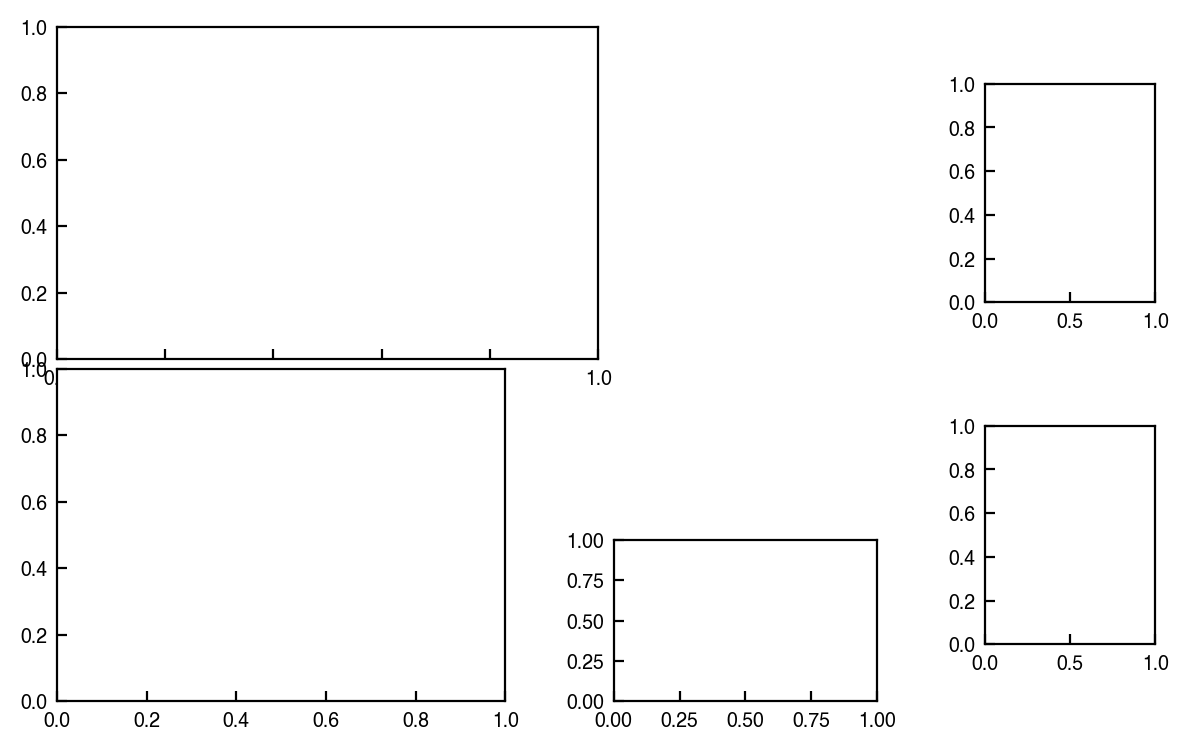

In [119]:
import matplotlib as mpl

columns = 2
rows = 1
#scol=(3+3/8) #single column width of PRL,
#dcol=2*scol # double column,
#size_col = scol*columns#[scol, dcol][columns-1]
#size_row = scol*rows#scol, dcol][rows-1]

mmtoinch = 1/25.4
scol = 88 * mmtoinch
dcol = 180 * mmtoinch
size_col = [scol, dcol][columns-1]
if columns == 1:
    size_row = scol*rows
else:
    size_row = dcol*rows

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": False,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(12,12)  # 2x2 grid
ax_a = fig.add_subplot(gs[0:6,:6])
ax_b = fig.add_subplot(gs[6:12,:5])
ax_c = fig.add_subplot(gs[1:5,10:])
ax_d = fig.add_subplot(gs[7:11,10:])
ax_e = fig.add_subplot(gs[9:12,6:9])
ax_z = fig.add_subplot(gs[0:9,6:10])
#Turn off all displayed aspects of ax_z:
ax_z.axis('off')
ax_z.set_xticks([])
ax_z.set_yticks([])
ax_z.set_xticklabels([])
ax_z.set_yticklabels([])

#ax_c = fig.add_subplot(gs[10:,1:4])
#ax_d = fig.add_subplot(gs[10:,6:10])

#fig2 = plt.figure()
#gs2 = gridspec.GridSpec(5,60)  # 2x2 grid
#ax_c = fig2.add_subplot(gs2[2:5,0:60])
#ax_d = fig2.add_subplot(gs2[0:2,0:60])


In [120]:
""" Oscillations without frequency corrections. Imports data from experiments, then performs processing and plotting. """
#Data sets from "Round 2 Verification" and "Round 2 Initial"
#np.savez('data_dump', times = t_w_data['x']*us, thetas = thetas, qubits = qubit_index, Omegas = Omegas, data=t_w_data['probs'])

#cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
cmap = cm.get_cmap('Reds')
#Crop the lowest points from cmap, start at 0.5:




## START NOT AT 0:



initial_file = np.load("../data/ROUND_2_INITIAL/data_dump.npz")

plotting_version = 1

times = initial_file['times']
thetas = initial_file['thetas']
qubits = initial_file['qubits']
Omegas = initial_file['Omegas']
#print(Omegas[0])
data = initial_file['data']
std_matrix = initial_file['std_matrix']
#print(data.shape)
#print(data.shape)
qubit_to_use = 2
qubit_index_full = qubits[qubit_to_use]
data_qubit = data[:,qubit_index_full,:]
stds_qubit = std_matrix[:,qubit_index_full,:]
#print(data_qubit.shape)
theta_qubit = thetas[:,qubit_to_use]
#print(theta_qubit)
Omega_qubit = Omegas[:,qubit_to_use]
#print(thetas)

sorting_index = np.argsort(theta_qubit)
theta_qubit = theta_qubit[sorting_index]
data_qubit = data_qubit[sorting_index]
stds_qubit = stds_qubit[sorting_index]
Omega_qubit = Omega_qubit[sorting_index]

#ax_a.legend()
#######################
#Redoing the color bar:
def create_linear_function(y_at_0_5):
    # Given points
    x1, y1 = 0.5, y_at_0_5
    x2, y2 = 1, 1
    
    # Calculate slope (a) and intercept (b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    # Return the linear function
    def linear_function(x):
        return a * x + b
    
    return linear_function

linear_func = create_linear_function(0.5)

print(theta_qubit)

new_labels = ['0.04', '0.08', '0.12', '0.16', '0.20']
new_tick_locations = linear_func(np.array([0.04, 0.08, 0.12, 0.16, 0.20])/max(theta_qubit))

normalized_ZNE_points_for_color = linear_func(theta_qubit/max(theta_qubit))
#cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in normalized_ZNE_points_for_color ]
cmap = LinearSegmentedColormap.from_list('name', Reds)
print(Reds)
#get a blue to red colormap
colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))
#make a test plot that just plots all the reds



#print(colors)
# Add a color bar:
colorbar = plt.cm.ScalarMappable(cmap=cmap)
#colorbar.set_array(ZNE_points[1:] * baseline)

# Add color bar to ax_bii
labels = np.array(['{:.3f}'.format(theta_qubit[i]) for i in range(len(theta_qubit))])

cbar = plt.colorbar(colorbar, ax=ax_a, ticks=new_tick_locations)
cbar.set_label(r'Temperature ($\theta$)',usetex=1)

#cbar.set_label(r'Standard Deviation, $\sigma$', labelpad=5)
#labels[0] = ''
cbar.set_ticklabels(new_labels)

#####################


for index in range(len(theta_qubit)):
    ax_a.plot(times, data_qubit[index], color=colors[index], label=theta_qubit[index], linewidth=1)#, yerr=stds_qubit[index])#, alpha=max(0.2,(1/(index+1))))
    ax_a.fill_between(times, data_qubit[index] - stds_qubit[index], data_qubit[index] + stds_qubit[index], color=colors[index], alpha=0.15)
ax_a.plot(times, (0.5 - np.cos(Omega_qubit[0]*times)/2), color='black', zorder=100, ls='--', lw=0.8)

[0.057793   0.06574115 0.07655879 0.10509314 0.11692185 0.15612184
 0.15612184 0.18123138 0.2261819 ]
[(0.9882352941176471, 0.7270280661284121, 0.6241445597846982, 1.0), (0.9882352941176471, 0.6816301422529797, 0.5721030372933488, 1.0), (0.9882352941176471, 0.6210995770857363, 0.5027143406382161, 1.0), (0.9854825067281815, 0.46243752402921956, 0.3369473279507882, 1.0), (0.9776701268742791, 0.38966551326412935, 0.27358708189158026, 1.0), (0.8636216839677047, 0.15978469819300267, 0.14186851211072665, 1.0), (0.8636216839677047, 0.15978469819300267, 0.14186851211072665, 1.0), (0.7317954632833525, 0.07889273356401384, 0.10019223375624758, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_79464/1717679346.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


<Figure size 1417.32x875.954 with 0 Axes>

In [121]:
#Make 3 vertically arranged boxes, which are all the same size, containing the following text:
"""

Fit the Frequency and Temperature for each qubit and time
Extract the linear fit of Frequency vs Temperature
Update the time such that the frequencies are correct
"""
width = 0.8
height = 0.3
x_start = 0.1

box_x, box_y = x_start, 0.7
box_width, box_height = width, height

# Add the rectangle patch
rect = plt.Rectangle((box_x, box_y), box_width, box_height,
                     facecolor='none', edgecolor='black', lw=1)
ax_z.add_patch(rect)

# Place text inside the rectangle, adjusting coordinates as needed
ax_z.text(box_x + 0.01, box_y + box_height - 0.01,
        "Fit the Frequency and\n Temperature for each qubit and time",
        va='top', ha='left', wrap=True)

box_x, box_y = x_start, 0.4
box_width, box_height = width, height

# Add the rectangle patch
rect = plt.Rectangle((box_x, box_y), box_width, box_height,
                     facecolor='none', edgecolor='black', lw=1)
ax_z.add_patch(rect)

# Place text inside the rectangle, adjusting coordinates as needed
ax_z.text(box_x + 0.01, box_y + box_height - 0.01,
        "Extract the linear fit of\n Frequency vs Temperature",
        va='top', ha='left', wrap=True)

box_x, box_y = x_start, 0
box_width, box_height = width, height

# Add the rectangle patch
rect = plt.Rectangle((box_x, box_y), box_width, box_height,
                     facecolor='none', edgecolor='black', lw=1)
ax_z.add_patch(rect)

# Place text inside the rectangle, adjusting coordinates as needed
ax_z.text(box_x + 0.01, box_y + box_height - 0.01,
        "Update the time such\n that the frequencies are correct",
        va='top', ha='left', wrap=True)
#ax_z.text(0.5, 0.9, r'Fit the Frequency and Temperature for each qubit and time', ha='center', va='center', fontsize=10, usetex=1,wrap=True, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', width=1))
#ax_z.text(0.5, 0.6, r'Extract the linear fit of Frequency vs Temperature', ha='center', va='center', fontsize=10, usetex=1)
#ax_z.text(0.5, 0.3, r'Update the time such that the frequencies are correct', ha='center', va='center', fontsize=10, usetex=1)




"""Old: r'For each $\{t_{w,i}\}$ \\ find $\theta_i$, $\Omega_i$ from Eq. ??', usetex=1
r'Fit \dot{\Omega}_i\theta_i + \Omega_{i,0}$, usetex=1
r'Update $t_{w,i}$ such that \\ $\Omega_{T} = \dot(\Omega_i}(\dot{\theta}_i t_{w,i} + \theta_{i,0}) + \Omega_{i,0}$, usetex=1
"""

"Old: r'For each $\\{t_{w,i}\\}$ \\ find $\theta_i$, $\\Omega_i$ from Eq. ??', usetex=1\nr'Fit \\dot{\\Omega}_i\theta_i + \\Omega_{i,0}$, usetex=1\nr'Update $t_{w,i}$ such that \\ $\\Omega_{T} = \\dot(\\Omega_i}(\\dot{\theta}_i t_{w,i} + \theta_{i,0}) + \\Omega_{i,0}$, usetex=1\n"

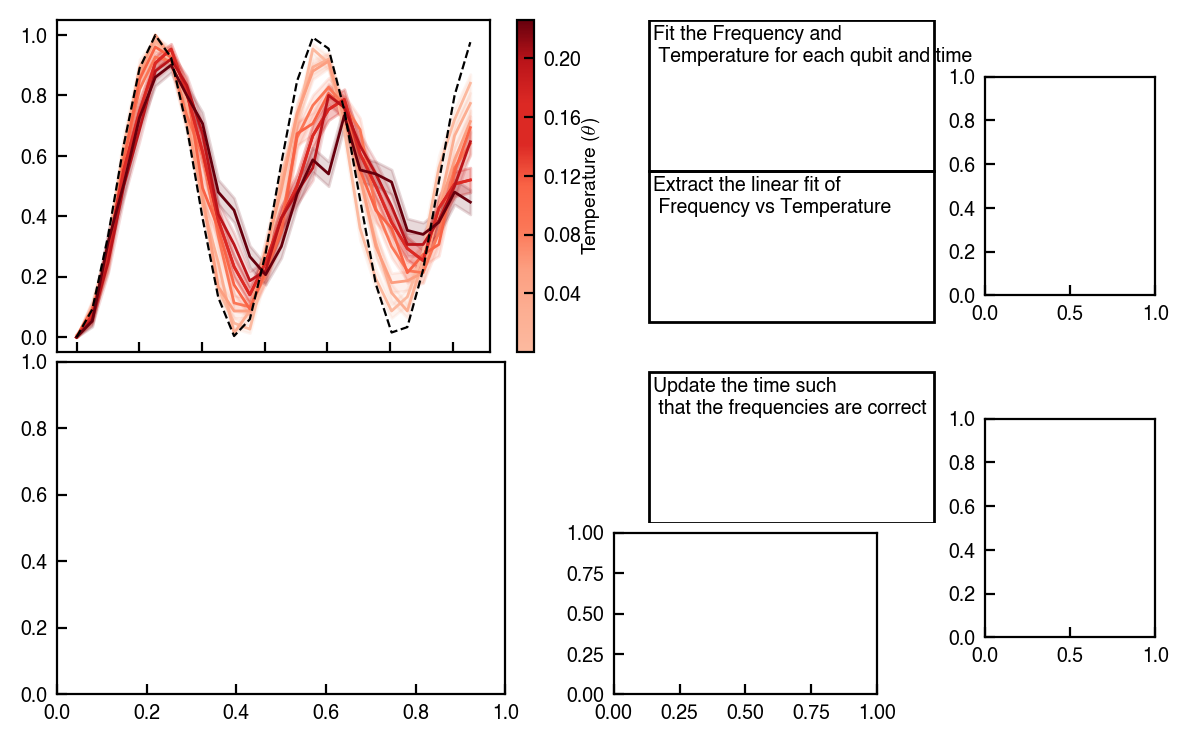

In [122]:
fig

In [123]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
x, y = 0.9, 0
ax_inset = inset_axes(ax_b, width="30%", height="70%", bbox_to_anchor=(x, y, 1, 1), bbox_transform=ax_b.transAxes, loc='lower left')

# Define the x-range and y-range to zoom in on
x_inset_range = (9e-6, 10e-6)
y_inset_range = (0.6, 1)

# Plot data in the inset axes
# ax_c.plot(x, y, label='Inset Data')  # Uncomment and replace with actual data
ax_inset.set_xlim(x_inset_range)
ax_inset.set_ylim(y_inset_range)

# Optional: Add a box showing the zoomed area
inset_zoom = ax_b.indicate_inset_zoom(ax_inset, edgecolor="k", )
connector_lines = inset_zoom[1]  # The connector lines are returned as a tuple
connector_lines[0].set_visible(True)  # Hide the lower-left connector line
connector_lines[1].set_visible(False)   # Show the upper-left connector line
connector_lines[2].set_visible(False)   # Show the lower-right connector line
connector_lines[3].set_visible(True)  # Hide the upper-right connector line

# Turn off the Y axis in the inset
#ax_c.yaxis.set_visible(False)
#ax_c.set_yticklabels([])
ax_inset.set_xticks([ 0.1, 0.2])
ax_inset.set_xticklabels([ '0.1', '0.2'])
ax_inset.set_yticks([0.8])
ax_inset.set_yticklabels(['0.8'])
ax_inset.set_xlabel(r'Temperature ($\theta$)',usetex=1)


# Move the labels inside the plot
ax_inset.tick_params(axis='x', direction='in', labeltop=False, labelbottom=True)
ax_inset.tick_params(axis='y', direction='in', labelleft=True, labelright=False)#, pad=-50)

#ax_c.set_xticklabels(ax_c.get_xticks(), )

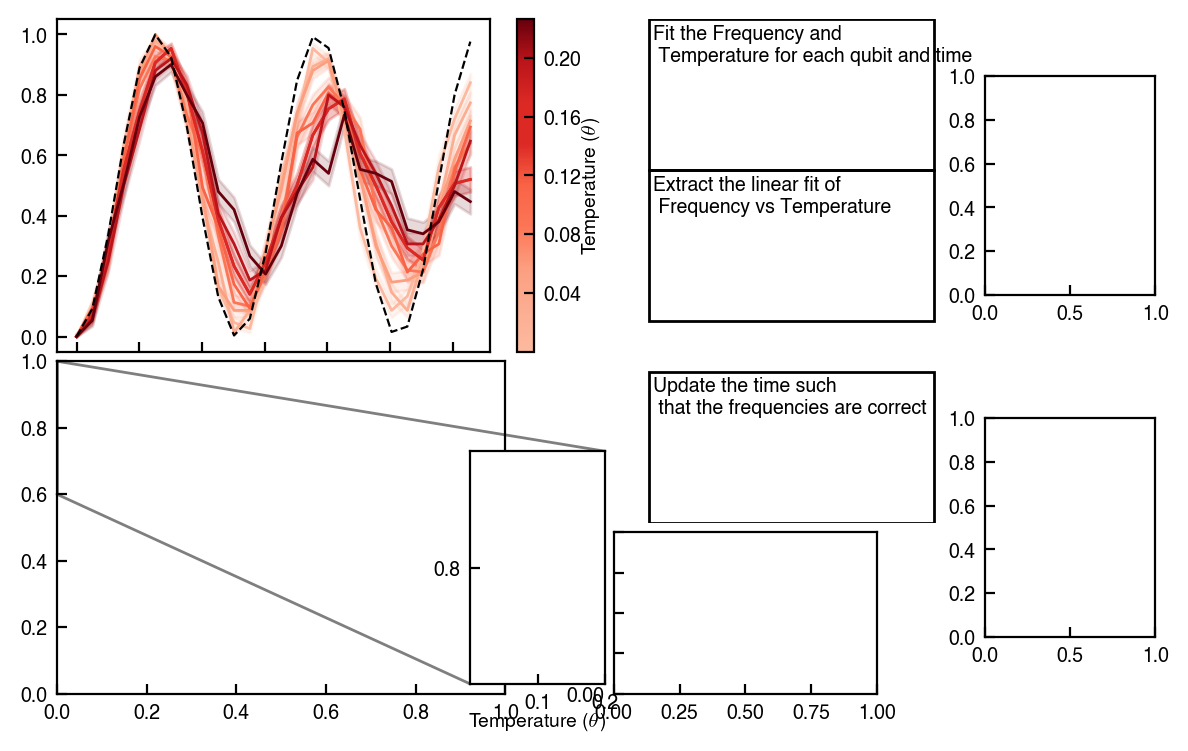

In [124]:
fig

(9, 23, 26)
(9, 4)
(9, 4)
[0.067054   0.05348242 0.0674449  0.15684063 0.15684063 0.09614671
 0.11562191 0.17775948 0.23842394]
[0.067054   0.05348242 0.0674449  0.15684063 0.15684063 0.09614671
 0.11562191 0.17775948 0.23842394]


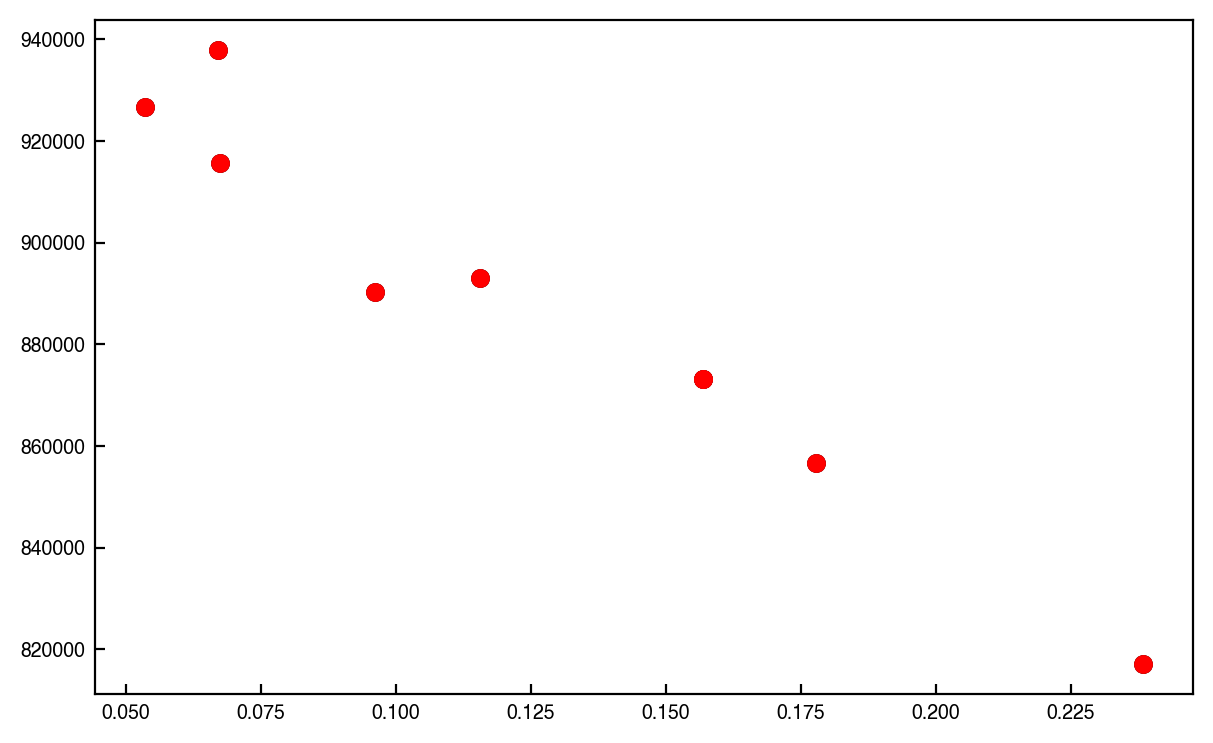

In [125]:
#Calibration:
calibration_file = np.load("../data/ROUND_2_INITIAL/data_dump.npz")
init_times = calibration_file['times']
init_thetas = calibration_file['thetas']
init_qubits = calibration_file['qubits']
init_Omegas = calibration_file['Omegas']
init_data = calibration_file['data']
init_stds = calibration_file['std_matrix']
qubit_to_use = 3#2

#Plot theta vs. Omega
plt.scatter(init_thetas[:,qubit_to_use], init_Omegas[:,qubit_to_use], label='Initial', color='black', lw=0.8)
plt.scatter(thetas[:, qubit_to_use], Omegas[:, qubit_to_use], label='Final', color='red', lw=0.8)
#Add error bars:
print(init_stds.shape)
#plt.errorbar(init_thetas[:,qubit_to_use], init_Omegas[:,qubit_to_use], yerr=0.01, xerr=0.01, fmt='o', color='black', lw=0.8)
print(thetas.shape)
print(init_thetas.shape)
print(thetas[:, qubit_to_use])
print(init_thetas[:,qubit_to_use])


In [126]:
""" Oscillations without frequency corrections. Imports data from experiments, then performs processing and plotting. """
#Data sets from "Round 2 Verification" and "Round 2 Initial"
#np.savez('data_dump', times = t_w_data['x']*us, thetas = thetas, qubits = qubit_index, Omegas = Omegas, data=t_w_data['probs'])

#cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])

initial_file = np.load("../data/ROUND_2_VERIFICATION/data_dump.npz")

plotting_version = 1

times = initial_file['times']
thetas = initial_file['thetas']
qubits = initial_file['qubits']
Omegas = initial_file['Omegas']
data = initial_file['data']
std_matrix = initial_file['std_matrix']
#print(data.shape)
#print(data.shape)
#qubit_to_use = 2
qubit_index_full = qubits[qubit_to_use]
data_qubit = data[:,qubit_index_full,:]
stds_qubit = std_matrix[:,qubit_index_full,:]
#print(data_qubit.shape)
theta_qubit = thetas[:,qubit_to_use]
#print(theta_qubit)
Omega_qubit = Omegas[:,qubit_to_use]
#print(thetas)

#Sort based on ascending theta_qubit. Sort all of the above





for index in range(len(thetas)):
    ax_b.plot(times, data_qubit[index], color=colors[index], label=theta_qubit[index], linewidth=1)#, yerr=stds_qubit[index])#, alpha=max(0.2,(1/(index+1))))
    ax_b.fill_between(times, data_qubit[index] - stds_qubit[index], data_qubit[index] + stds_qubit[index], color=colors[index], alpha=0.15)
ideal_data = 0.5 - np.cos(Omega_qubit[0]*times)/2
ax_b.plot(times, (0.5 - np.cos(Omega_qubit[0]*times)/2), color='black', zorder=100, ls='--', lw=0.8)
#ax_a.legend()

#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(thetas[qubit_to_use])))
#sm.set_array([])
#Add a label to the color bar:

#Performing ZNE:


#ZNE_function = order_poly_instance(5, debug=True)
ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, y_error=weights)



ZNE_data = np.zeros(len(times))
ZNE_functions = []
print(data_qubit.shape)
for index in range(len(times)):
    #print(data_qubit[:,index])
    fitted_function = ZNE_function(theta_qubit,data_qubit[:,index], weights=stds_qubit[:,index])
    print(fitted_function)
    ZNE_data[index] = fitted_function(0)
    ZNE_functions.append(fitted_function)

    


ax_b.plot(times, ZNE_data, color='blue')
#Draw the vertical slice: 


index_of_slice = 15


#print(data_qubit[:,index_of_slice])
#ax_b.axvline(x=times[index_of_slice], color='black', ls=':')
#print(ZNE_data.shape)
for theta_index in range(len(theta_qubit)):
    ax_inset.errorbar(theta_qubit[theta_index], data_qubit[theta_index, index_of_slice], color=cmap(theta_index/len(thetas)), yerr=stds_qubit[theta_index, index_of_slice], linewidth=1)
    ax_inset.scatter(theta_qubit[theta_index], data_qubit[theta_index, index_of_slice], color=cmap(theta_index/len(thetas)), s=10)


dense_theta = np.linspace(0, max(theta_qubit), 1000)
ax_inset.plot(dense_theta, ZNE_functions[index_of_slice](dense_theta), color='blue', label='ZNE Fit')
ax_inset.set_xlim(0, max(theta_qubit)+0.01)


ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, y_error=weights)
ZNE_function(theta_qubit,data_qubit[:,index_of_slice], weights=stds_qubit[:,index_of_slice])

"""Generate Simulation Data using Cetina Function and SPAM?"""
theta_axis_data = np.zeros((len(dense_theta), len(times)))
Omega_ideal = Omegas[0, qubit_to_use]
#print(Omega_qubit)
Omega_scaled = np.abs(calibrate_sim_Omegas(dense_theta, Omega_ideal, times))*Omega_ideal
#ax_b.plot(times, cetina_thermal_exp(times, 0, Omega_scaled[0]))
#NEED TO CORRECT THIS FREQUENCY
for theta_index in range(len(dense_theta)):
    theta = dense_theta[theta_index]
    theta_axis_data[theta_index] = cetina_thermal_exp(times, theta, Omega_scaled[theta_index])

#ax_inset.plot(dense_theta, theta_axis_data[:,index_of_slice], color='black', linestyle='--', label='Numerical')
ax_inset.scatter(0, ideal_data[index_of_slice], color='black', s=10)

#Error plot: Take the largest error up  to the time and plot on a log plot
baseline_error = np.abs(data_qubit[0] - ideal_data)
ZNE_error = np.abs(ZNE_data - ideal_data)

rolling_max_basline_error = np.maximum.accumulate(baseline_error)
rolling_max_ZNE_error = np.maximum.accumulate(ZNE_error)

#ax_d.plot(times, rolling_max_basline_error, label=r'$\theta$ = {:.2f}'.format(theta_qubit[0]), color='black')
#ax_d.plot(times, rolling_max_ZNE_error, label='ZNE', color='blue')
#ax_d.set_ylabel('Absolute error')
#ax_d.set_yscale('log')
#ax_d.hlines(stds_qubit[0,index_of_slice], times[0], times[-1], color='red', ls='--', label='Shot Noise')
#ax_d.legend()


#cbar_b = fig.colorbar(sm, ax=ax_b)
#cbar_b.set_label(r'$\theta$')

# s
##NEED STANDARD DEVIATION
#THE INDEXES ARE NOT IN ORDER???

(9, 26)
[nan, 3.949652777777712e-05, 3.681745835491747e-05, 4.129633405016787e-05, 0.0001275099796589821, 0.0014038303174825886, 0.7962607869005095, 3.794004878412707]
2
0.0 + 0.0·x¹ + 0.0·x²
[nan, 0.004660590277538883, 0.003963089749985703, 0.0031803524663615145, 0.003970252743380754, 0.09232724997451744, 14.98231296342246, 18304.664797528327]
3
0.0947661628887046 + 0.0·x¹ - 2.2074701237683367·x² + 9.560806371964489·x³
[nan, 0.0891718749852417, 0.08959158644026745, 0.06888116923692882, 0.2360683596715505, 0.5999920944348855, 2.6301108659299315, 145921.4200420246]
3
0.3500378411576115 + 0.0·x¹ - 10.741131557911878·x² + 50.27347091903207·x³
[nan, 0.09505121529581917, 0.034186000762141205, 0.038763925225260856, 0.07610684242840904, 5.947325434778005, 98.97373059659519, 23077.248453450313]
2
0.6063705251579936 + 0.0·x¹ - 2.432469722489118·x²
[nan, 0.11856293402773707, 0.017282319800026633, 0.017125556523003436, 0.013683188820396, 2.607515643993041, 15.667683964929497, 6413.80420180607]
4


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:931: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:526: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[nan, 0.08703906248931904, 0.010267365063076999, 0.010529740195876155, 0.058892271889504653, 0.14817634524259388, 198.86306135201232, 6156.322135300321]
2
0.9892247121267764 + 0.0·x¹ - 2.8069710192062844·x²
[nan, 0.02620312499975206, 0.00845053998573729, 0.008497818998013742, 0.011425759682188565, 0.008568088906336322, 50.967688413409924, 59468.69910927318]
2
0.9415152833022679 + 0.0·x¹ - 1.3403500705774523·x²
[nan, 0.04321484374818189, 0.016198385694807613, 0.021185416145169673, 0.09661816972615475, 1.2350376180592382, 126.56647753149738, 1963.7657747551195]
2
0.7350781841032594 + 0.0·x¹ + 1.5757641659641113·x²
[nan, 0.2163168402914827, 0.06536014307653723, 0.028127469621895752, 0.2990209223211544, 0.43936462747025007, 0.9484325034466754, 1282.9010166036337]
3
0.38378252054963896 + 0.0·x¹ + 17.75593161820586·x² - 68.4478943601755·x³
[nan, 0.31071918398042797, 0.04284805081335249, 0.024693150392954923, 0.03279445923140304, 0.07869563313360672, 27.121890395402488, 80284.43098558554]
3
0

In [ ]:


#Wait times
mu_wait_initial = np.array([0.000000, 0.119841, 0.359523, 0.719045, 0.958727, 1.198409, 1.797613, 2.396818, 3.595226])
mu_wait_verification = np.array([0.000000, 0.096831, 0.290494, 0.580987, 0.774650, 0.968312, 1.452468, 1.936624, 2.904936])
#wait_initial_ms = 

ms_wait = mu_wait_verification/409.6*1e3
Mega = 1e6
#Plot wait vs. theta:
ax_c.scatter(init_thetas[:,qubit_to_use], init_Omegas[:,qubit_to_use]/Mega, label='Initial', color='black', lw=0.8,marker='X')
#Linear fit:

#ax_c.plot(us_wait, linear(us_wait, *pop), color='black', ls='--', label='Initial Fit')

ybounds = ax_c.get_ylim()
updated_bounds = (ybounds[0], max(ybounds[1], max(Omegas[:,qubit_to_use])/Mega)+0.02)
#print(updated_bounds)

#Plot a linear fit for ax_c:

linear = lambda x, m, c: m*x + c
popt, pcov = curve_fit(linear, init_thetas[:, qubit_to_use], init_Omegas[:,qubit_to_use]/Mega)
ax_c.plot(init_thetas[:, qubit_to_use], linear(init_thetas[:, qubit_to_use], *popt), color='black', ls='--', label='Initial Fit')
print(linear(init_thetas[:, qubit_to_use], *popt))
ax_c.set_title('Pre-Calibration')
ax_d.set_title('Calibrated')
#Plot a linear fit for ax_d:

popt, pcov = curve_fit(linear, thetas[:, qubit_to_use], Omegas[:, qubit_to_use]/Mega)
ax_d.plot(thetas[:, qubit_to_use], linear(thetas[:, qubit_to_use], *popt), color='black', ls='--', label='Final Fit')

ax_c.set_ylim(updated_bounds)
ax_d.scatter(thetas[:,qubit_to_use], Omegas[:,qubit_to_use]/Mega, label='Calibrated', color='black', lw=0.8, marker='X')

ax_d.set_ylim(updated_bounds)
#ax_d_twin = ax_d.twinx()
#ax_d.scatter(thetas[:, qubit_to_use], Omegas[:, qubit_to_use], label='Final', color='red', lw=0.8)
#Add error bars:
#Make the twin axis red:

ax_e.scatter(ms_wait, init_thetas[:,qubit_to_use], label='Initial', color='black', lw=0.8,marker='X')
#Linear fit:
popt, pcov = curve_fit(linear, ms_wait, init_thetas[:,qubit_to_use])
ax_e.plot(ms_wait, linear(ms_wait, *popt), color='black', ls='--', label='Initial Fit')
slope = popt[0]
intercept = popt[1]
slope_uncertainty = np.sqrt(np.diag(pcov))[0]
intercept_uncertainty = np.sqrt(np.diag(pcov))[1]

import uncertainties
from uncertainties import ufloat

# Example values with uncertainties
slope = ufloat(slope, slope_uncertainty)  # slope with uncertainty
intercept = ufloat(intercept, intercept_uncertainty)  # intercept with uncertainty

# Format the text with uncertainties
slope_str = f'{slope:.1uS}'
intercept_str = f'{intercept:.1uS}'

ax_e.text(0.5, 0.5, rf'$\dot{{\theta}}:\,{slope_str}/\mathrm{{ms}}$ \\ $\theta_{{0}}: \, {intercept_str}$',usetex=1)

# Add the text to the plot
#ax_e.text(0.5, 0.5, rf'$\dot{{\theta}}:\,{slope_str}/\mathrm{{ms}}$\n$\theta_{{0}}: \, {intercept_str}$', 
#          ha='center', va='center', transform=ax_e.transAxes, usetex=1)

#print(slope, intercept)
#print(slope_uncertainty, intercept_uncertainty)

#ax_e.text(0.5, 0.5, rf'$\dot{{\theta}}:\,{slope:.3f}/\mathrm{{ms}}$\n$\theta_{{0}}: \, {intercept:.3f}$', 
#          ha='center', va='center', transform=ax_e.transAxes, usetex=1)

ax_e.set_xlabel(r'Wait Time ($ms$)',usetex=1)
ax_e.set_ylabel(r'Temperature ($\theta$)', usetex=1)
ax_e.set_title('Heating Rate')


ax_c.set_xlabel(r'Temperature ($\theta$)',usetex=1)
ax_c.set_ylabel(r'$\Omega$ ($\mathrm{MHz}$)', usetex=1)
ax_d.set_xlabel(r'Temperature ($\theta$)',usetex=1)
ax_d.set_ylabel(r'$\Omega$, ($\mathrm{MHz}$)', usetex=1)

ax_c.set_xlabel(r'$\theta$')



[0.92171356 0.92974444 0.92148225 0.86858297 0.86858298 0.90449816
 0.89297385 0.8562044  0.82030664]


Text(0.5, 427.5553277391765, '$\\theta$')

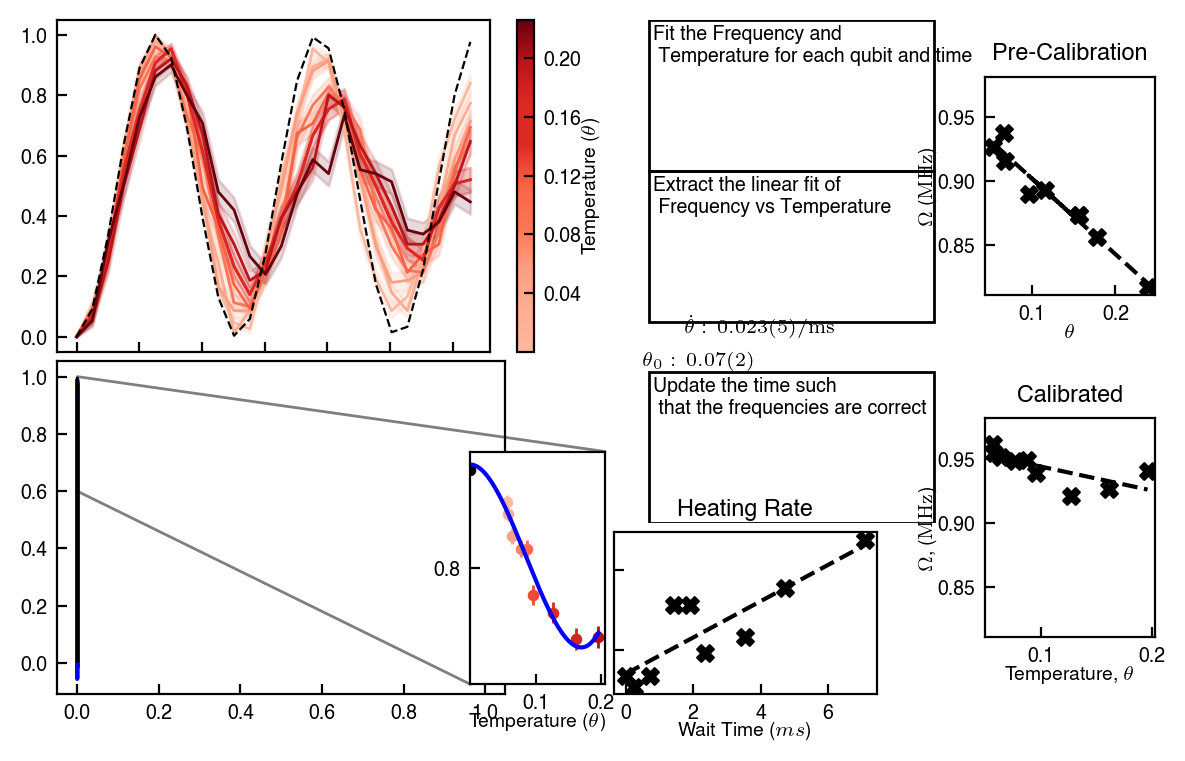

In [128]:
fig

In [129]:
ax_a.set_ylabel('Population Transfer')
ax_a.set_xlabel(r'Time ($\mu\mathrm{s}$)',usetex=1)
ax_a.set_xticks(np.array([0, .5, 1, 1.5])*1E-5)

ax_a.set_xticklabels([0, 5, 10, 15])
ax_b.set_xlim(0, 1.5E-5)
ax_a.set_xlim(0, 1.5E-5)

#cbar_b.set_label(r"$\theta$", labelpad=-21, y=1.08, rotation=0)
#cbar_a.set_label(r"$\theta$", labelpad=-21, y=1.08, rotation=0)

#ax_a.set_xticklabels([{:.2f}.format(x) for index in range(len(times, 5))])

#ax_c.set_xlabel(r'Temperature, $\theta$')
#ax_c.set_ylabel('Population Transfer')
#ax_c.legend()
#ax_b.set_ylabel('Population Transfer')
ax_b.set_xlabel(r'Time ($\mu\mathrm{s}$)',usetex=1)
ax_b.set_ylabel(r'Population Transfer', usetex=1)
#ax_b.set_yticklabels([])
ax_b.set_xticks(np.array([0, .5, 1])*1E-5)
ax_b.set_xticklabels([0, 5, 10])


fig.tight_layout()
fig.savefig("Figure_3_v3.pdf", bbox_inches='tight')
fig.savefig("Figure_3_v3.png", bbox_inches='tight', dpi=600)
fig.savefig("Figure_3_v3.svg", bbox_inches='tight', dpi=600)

/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_79464/3976374262.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_79464/3976374262.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


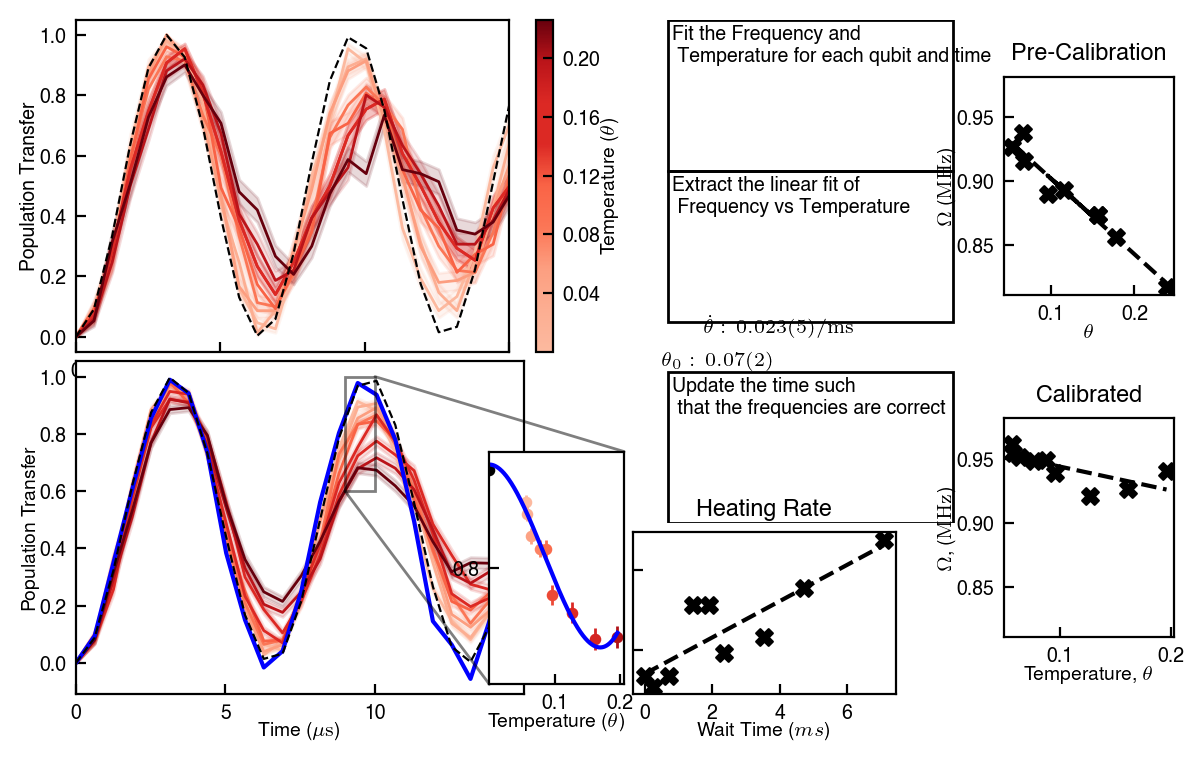

In [130]:
fig